In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.2 MB 4.7 MB/s 


###jpg랑 json 파일 읽어오기

In [2]:
path0 = '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image' # replace your data path
path1 = '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/json'
path2 = '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2'# crop한 이미지 저장용
# dpiv = 80

In [3]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    CenterSpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    ToTensord,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first
from monai.networks.nets import EfficientNet, EfficientNetBN

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import csv

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [5]:
path_list = glob.glob(os.path.join(path0,'*.jpg'))
path_list.sort()
len(path_list)# 가온집2 라는 폴더에 jpg파일 90개인거 확인하기

print(path_list[:3])


json_list = glob.glob(os.path.join(path1,'*.json'))
json_list.sort()
len(json_list)

print(json_list[:3])

['/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image/ACKS_MI_01000001_0020_001.jpg', '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image/ACKS_MI_01000001_0020_005.jpg', '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image/ACKS_MI_01000001_0020_006.jpg']
['/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/json/ACKS_MI_01000001_0020_001.json', '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/json/ACKS_MI_01000001_0020_005.json', '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/json/ACKS_MI_01000001_0020_006.json']


In [6]:
def extract_label(file_path):
  with open(file_path, 'r') as file:
      data = json.load(file)
      data= data['Image_Text_Coord']# 하나의 파일에 대한 bbox랑 label 넣기
  return data



In [7]:
train_ind = np.arange(0,70)# 총 90개였으니까
data_dicts = [
    {
        "image": os.path.join(path_list[idx]),# 여기에 이미지 70개 들어가고
        "label": extract_label(os.path.join(json_list[idx])),# 여기에 json파일 70개 들어가고
    }
    for idx in train_ind
]
train_files =  data_dicts

In [8]:
train_files[0]['label'][0][0]['label']# 한자 뽑아낼때는 이렇게 뽑아내야함
# 첫번째 0 -> 몇번째 파일이야
# 두번째 0-> 몇번째 column이야
# 세번째 0-> 그 column에서 몇번째 단어야
# 마지막 label -> 그 단어가 무슨 한자야

train_files[0]['label'][0][0]['bbox'] # bbox 뽑아낼때는 이렇게 뽑아내야함
# 첫번째 파일의 (0,0)위치의 한자는 [948.5,~~~~이 위치에 존재한다.

[948.5, 130.0, 121.0, 115.0, 0, 0]

In [9]:
valid_ind = np.arange(70,90)
data_dicts = [
    {
        "image": os.path.join(path_list[idx]),# 여기에 이미지 20개 들어가고
        "label": extract_label(os.path.join(json_list[idx])),# 여기에 json파일 20개 들어가고
    }
    for idx in valid_ind
]
valid_files =  data_dicts

# ㅇ여기까지 Train이랑 valid 나누는 것까지 했고

### label에 있는 json파일을 이용해서 image를 crop하고
### label에 있는 json파일을 이용해서 label로 한자도 다시 갖고 오고

In [10]:
train_files[0]['label'][0][0]['bbox']
# print(len(train_files[0]['label'][0]))
# 이런 식으로 bbox 레이블링 + label 

[948.5, 130.0, 121.0, 115.0, 0, 0]

In [11]:
train_files[0]['label'][0][0]['bbox'][0]

948.5

In [19]:
def crop_image(train_files):
  crop_image_list = []
  z = 0
  for i in range(len(train_files)):
    img = cv2.imread(train_files[i]['image'])# 이미지 불러오기

    for i2 in range(len(train_files[i]['label'])):
      for i3 in range(len(train_files[i]['label'][i2])):
        bbox = train_files[i]['label'][i2][i3]['bbox']
        x_1 = int(bbox[0])
        y_1 = int(bbox[1])
        w = int(bbox[2])
        h = int(bbox[3])
        crop_img = img[y_1:y_1+h, x_1:x_1+w]# 잘 잘리는 거 확인함
        cv2.imwrite('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/%d_crop.jpg' %(z), crop_img)
        z = z+1
        crop_image_list.append(crop_img)

  return crop_image_list    

In [20]:
def chinese_label(train_files):
  chinese_label_list = []
  for i in range(len(train_files)):
    for i2 in range(len(train_files[i]['label'])):
      for i3 in range(len(train_files[i]['label'][i2])):
        chinese = train_files[i]['label'][i2][i3]['label']
        chinese_label_list.append(chinese)

  return chinese_label_list

In [21]:
import cv2
a = crop_image(train_files)# ndarray로 들어가는 것 확인

print(len(a))

12692


In [22]:
b = chinese_label(train_files)# 여기는 한자로 들어가는 것도 확인
print(len(b))# 여기는 조각난 모든 파일에 대한 각 리스트 순서대로 레이블링 된 값들

12692


In [23]:
from collections import Counter
counter = Counter(b)
print(len(counter))# 전체 한자 개수
label = list(counter)
print(len(label))# 일단 전체 한자가 총 몇개인지는 알아야지

2315
2315


##1차 raw data를 train과 valid 파일로 이동시키는 과정

In [24]:
if not os.path.isdir('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/train'):# 이런 디렉토리가 없으면
  os.makedirs('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/train')# 이런 디렉토리를 만들어주고(train)

if not os.path.isdir('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/valid'):# 이런 디렉토리가 없으면
  os.makedirs('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/valid')# 이런 디렉토리를 만들어주고(valid)


In [25]:
import shutil
start_num = int(len(a)*0.8)
for i in range(2220, start_num):
  shutil.move('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/%d_crop.jpg' %(i),'/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/train' )
#여기까지 train image들 집어넣기

for z in range(start_num, len(a)):
  shutil.move('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/%d_crop.jpg' %(z),'/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/valid' )

#여기까지 valid image들 집어넣기

In [26]:
print(len(os.listdir('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/train')))
print(len(os.listdir('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/valid')))

7933
2539


### 앞에서 이미지 crop까지 끝냈고 -> 전처리 과정
## Image data loader

In [69]:
path_train = '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/1'# crop한 이미지들 들어가 있음
path_valid = '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/2'

# 여기서 8:2로 우리가 알아서 분류해서 진행하기로함

In [85]:
output = glob.glob('/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/1/train/*.jpg')
output.sort()
print(output[:3])

['/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/1/train/10000_crop.jpg', '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/1/train/10001_crop.jpg', '/content/drive/MyDrive/commit_folder/ocr/deep-text-recognition-benchmark-master/ch_dataset/hangseo/가은집_02/image2/1/train/10002_crop.jpg']


In [71]:
import torchvision
import torchvision.transforms as transforms
import torch

batch_size = 128

train_transforms = transforms.Compose(
      [
          transforms.Grayscale(num_output_channels=1),
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

#사용 transform

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)

train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [72]:
tgtnames = b# 이미지 crop된 값과 똑같은 순서대로 들어있는 label list # 12692개
print(tgtnames[:3])
print(len(tgtnames))

['祭', '文', '墓']
12692


In [73]:
from matplotlib import font_manager

fontP = font_manager.FontProperties()

torch.Size([128])
torch.Size([128, 1, 64, 64])


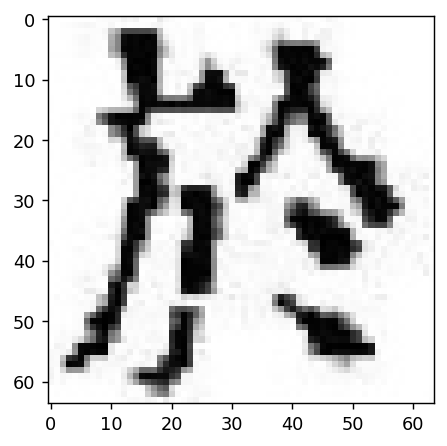

祭


In [76]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0][0].numpy()
plt.figure(dpi=128)
plt.imshow(I,cmap='gray')
# plt.legend(tgtnames[labels[0]], prop=fontP)
# plt.title(tgtnames[labels[0]], fontproperties=fontP)
plt.show()
# print(tgtnames[labels[0]])
print(tgtnames[labels[1]])

##Model 정의하기

In [32]:
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride = 1, padding=2),# 인풋으로 이미지 하나 들어가는 거니까
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride = 1, padding = 2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=32*16*16, out_features=4000),
    nn.ReLU(),
    nn.Linear(4000, 3000),
    nn.ReLU(),
    nn.Linear(3000, 12692)# 아웃풋으로 총 12692개의 한자 레이블 값에 대한 풀이 
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=8192, out_features=4000, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4000, out_features=3000, bias=True)
  (10): ReLU()
  (11): Linear(in_features=3000, out_features=12692, bias=True)
)

## Setting Hyperparameter


In [88]:
# setting hyper-parameters
learning_rate = 0.00056
num_epochs = 100

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

In [89]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    net.train()
    for X,y in train_iter:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    net.eval()
    for X,y in valid_iter:
        X,y = X.to(device),y.to(device)
        y_hat = net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#        plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  2.6769837037840436e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 5 
train loss:  2.6725796370526717e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 10 
train loss:  2.667859887644168e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 15 
train loss:  2.6633037299278283e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 20 
train loss:  2.659092828135697e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 25 
train loss:  2.654596755746752e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 30 
train loss:  2.650148094436454e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 35 
train loss:  2.64544430519304e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 40 
train loss:  2.6408451958559453e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 45 
train loss:  2.6363789314223876e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 50 
train loss:  2.6319438831940775e-06
train accuracy:  1.0
valid accuracy:  1.0
epoch: 55 
train loss:  2.627

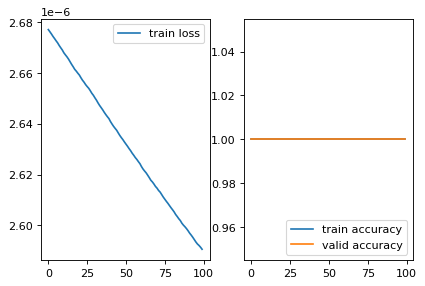

In [90]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

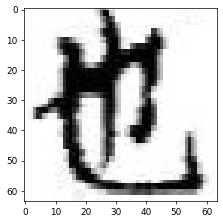

label: 祭 
 prediction: 祭


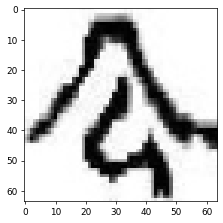

label: 祭 
 prediction: 祭


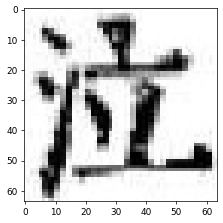

label: 祭 
 prediction: 祭


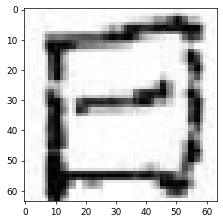

label: 祭 
 prediction: 祭


In [94]:
i = 0
y_list = np.array([])
y_hat_list = np.array([])
for X,y in valid_iter:
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)

  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

  if i == 0:
    for n in range(4):
      plt.figure(dpi=64)
      plt.imshow(X[n].cpu().squeeze(),cmap='gray')
      plt.pause(.0001)

      print('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
  i=i+1



In [37]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [49]:
len(tgtnames)
tgtnames[0]
tgtnames[1]

'文'

In [92]:
print(classification_report(
    y_list,
    y_hat_list))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2539

    accuracy                           1.00      2539
   macro avg       1.00      1.00      1.00      2539
weighted avg       1.00      1.00      1.00      2539



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31085 missing from current font.
  font.set_text(s, 0, flags=flags)


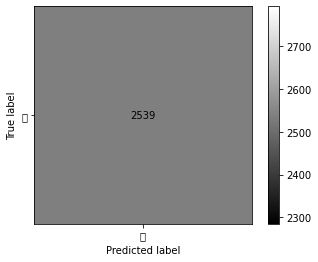

In [93]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1],cmap='gray')